In [7]:
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl

import sys
sys.path.append("../")
import GSHEWaveform
from pycbc.waveform import get_fd_waveform
%load_ext autoreload
%autoreload 2


def setmplstyle(fpath=None):
    """
    Set the matplotlib style. If `fpath` is `None` uses the default style.
    Arguments
    ---------
    fpath: str, optional
        Path to the style text file.
    """
    if fpath is None:
        mpl.rcParams.update(mpl.rcParamsDefault)
    else:
        mpl.style.use(fpath)


def ylabel_withoffset(ax, label):
    """
    Draw the y-label of the given axis with its offset.
    Arguments
    ---------
    ax: py:class:`matplotlib.axes._subplots.AxesSubplot`
        Matplotlib axis.
    label: str
        They y-axis label.
    """
    ax.yaxis.offsetText.set_visible(False)
    offset = ax.yaxis.get_major_formatter().get_offset()
    ax.set_ylabel(r"{} {}".format(label, offset))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
epsilons = np.load("../results/letter_eps.npy")
Xgeo = np.load("../results/letter_Xgeo.npy")
Xgshe = np.load("../results/letter_Xgshe.npy")

m = epsilons > 10**(-3.5)
epsilons = epsilons[m]
Xgshe = Xgshe[:, :, m, :]
from scipy import constants as const
Modot = 1.989e30
M = 5e4 * Modot

# in ms
t2tau = const.G * M / const.c**3 * 1e3

Xgeo[:, 2] *= t2tau
Xgshe[..., 2] *= t2tau

<IPython.core.display.Javascript object>


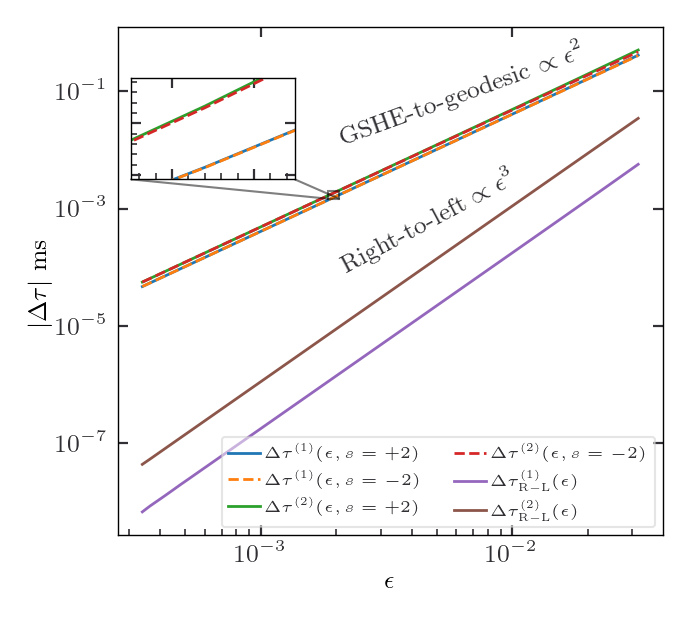

In [3]:
# setmplstyle()
setmplstyle("../plot_style.txt")

polardict = {0: "+2", 1: "-2"}
polarls = {0: "-", 1: "dashed"}
# default_mplstyle()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.45 * 1, 3.45 * 0.9))
# fig.subplots_adjust(hspace=0, wspace=0.275)

# Inset axes
axins = ax.inset_axes([0.025, 0.7, 0.3, 0.2])

for igeo in [0, 1]:
    for s in [0, 1]:
        dtgeo = Xgshe[igeo, s, :, 2] - Xgeo[igeo, 2]

        label = r"$\Delta \tau^{{({})}}(\epsilon, s={})$".format(igeo+1, polardict[s])
            
        ax.plot(epsilons, np.abs(dtgeo), ls=polarls[s], label=label)
        axins.plot(epsilons, np.abs(dtgeo), ls=polarls[s])
    
for igeo in [0, 1]:
    dtpol = np.abs(Xgshe[igeo, 0, :, 2] - Xgshe[igeo, 1, :, 2])
    label = r"$\Delta \tau_{{\rm R-L}}^{{({})}}(\epsilon)$".format(igeo+1,)
    ax.plot(epsilons, dtpol, label=label)
        

# sub region of the original image
x1, x2, y1, y2 = 1.85e-3, 2.05e-3, 6e-6 * t2tau, 8e-6 * t2tau
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
axins.set_yticklabels([])


ax.indicate_inset_zoom(axins, edgecolor="black")

        
plt.savefig("/Users/richard/Downloads/_tmp.png")

ax.legend()
ax.set_xlabel(r"$\epsilon$")
ax.set_xscale("log")
    

ax.legend(ncol=2, fontsize=5.75, frameon=True, framealpha=0.5, handlelength=2)
ax.set_ylabel(r"$|\Delta \tau| ~ \mathrm{ms}$")


ax.set_yscale("log")
ax.set_yscale("log")


# Slope comments
ax.text(0.4, 0.98, r"GSHE-to-geodesic $\propto \epsilon^2$", transform=ax.transAxes,
        verticalalignment='top', rotation=20)
ax.text(0.4, 0.73, r"Right-to-left $\propto \epsilon^3$", transform=ax.transAxes,
        verticalalignment='top', rotation=28)


plt.tight_layout()
fig.savefig("/Users/richard/Downloads/configuration_delay.png", bbox_inches="tight", dpi=450)
fig.show()

In [4]:
f_min = 40
f_max = 1024
M = 5e4

waveform_params = {"approximant": "IMRPhenomXP", "mass1": 50, "mass2": 35, "spin1z": 0.7,
                   "inclination": 0.9*np.pi}

delta_f = 0.001
left_taper = 20
right_taper = 50

left_window = (f_min - left_taper, f_min)
right_window = (f_max, f_max + right_taper)

fhplus, fhcross = get_fd_waveform(**waveform_params, delta_f=delta_f, f_lower=f_min - left_taper,
                                  f_final=f_max+right_taper)

In [5]:
temp_spacing = t2tau * 0.20050701082503508 * 1e-3

<IPython.core.display.Javascript object>


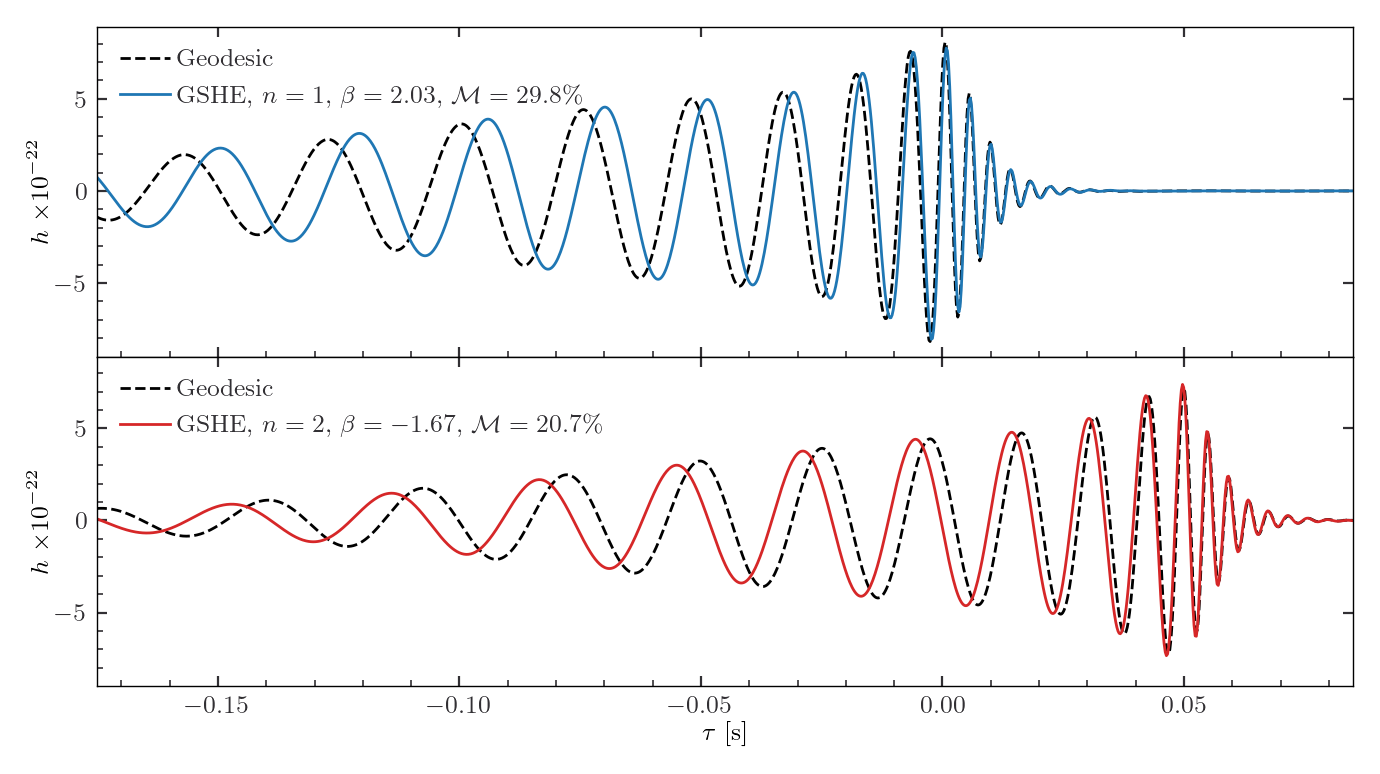

In [12]:
GSHEWaveform.setmplstyle("../plot_style.txt")

cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
fhright, fhleft = GSHEWaveform.linear_to_circular(fhplus, fhcross)
thright = GSHEWaveform.fd_to_td_fiducialshift(fhright, left_window, right_window)
max_eps = 0.1
M = GSHEWaveform.M_from_epsfreq(max_eps, f_min)


fig, axs = plt.subplots(nrows=2, figsize=(3.45 * 2, 2.58 * 1.5), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0)

for i, beta in enumerate([2.03, -1.67]):
    dt = 0.049394428491011076 if i == 1 else 0
    sc = 0.8871726646664084 if i == 1 else 1
    axs[i].plot(thright.sample_times + dt, sc * thright.data, label="Geodesic", ls="dashed", c="k")


    rdelay = lambda f: GSHEWaveform.time_delay_analytical(f, M, 2.0, beta)
    mismatch = GSHEWaveform.circular_mismatch(fhright, f_min, f_max, rdelay)

    fhright_gshe = GSHEWaveform.gshe_to_circular(fhright, rdelay)
    thright_gshe = GSHEWaveform.fd_to_td_fiducialshift(fhright_gshe, left_window, right_window)
    
    if beta > 0:
        col = "tab:blue"
    else:
        col = "tab:red"
    axs[i].plot(thright_gshe.sample_times + dt, sc * thright_gshe.data, c=col,
             label=r"GSHE, $n={}$, $\beta = {}$, $\mathcal{{M}} = {:.1f}\%$".format(i+1, beta, 100*mismatch))
    
    
    axs[i].set_xlim(-0.175, 0.025 + 0.06)
    axs[i].legend(loc="upper left")
    
plt.savefig("/Users/richard/Downloads/_tmp.png")

for i in range(2):
    GSHEWaveform.ylabel_withoffset(axs[i], r"$h$")
    
axs[1].set_xlabel(r"$\tau ~[\mathrm{s}]$")
plt.tight_layout(h_pad=0)
plt.savefig("/Users/richard/Downloads/circ_waveform.pdf", dpi=450, bbox_inches="tight")
fig.show()

(-8.990474751160976e-22, 8.902462618538378e-22)

In [212]:
data = GSHEWaveform.read_shooting(13, "../results", 0.2)
grid = data["grid"]
alphas = data["alphas"]
betas = data["betas"]

hull = GSHEWaveform.build_shadowhull(grid, betas[:, 0], N=200)
vals = GSHEWaveform.fillshadow(grid, betas[:, 0], hull)

Eliminating 147 point due to beta with average 0.9592 loops.


<IPython.core.display.Javascript object>


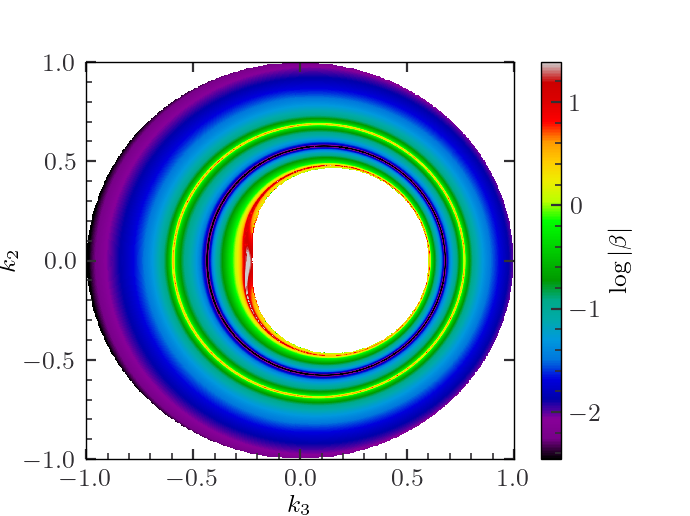

In [216]:
X, Y, Z = GSHEWaveform.smoothshadow(grid, np.log10(vals), 2500, method="linear")
qs = [1, 99.9] # Colourbar percentiles

# GSHEWaveform.setmplstyle("../plot_style.txt")

fig, ax = plt.subplots()
vmin, vmax = np.percentile(Z[~np.isnan(Z)].reshape(-1,), qs)
cm = ax.pcolormesh(-X, Y, Z, shading="auto", cmap="nipy_spectral", rasterized=True, vmin=vmin, vmax=vmax)


fig.colorbar(cm, ax=ax, label=r"$\log |\beta|$")
ax.set_xlabel("$k_3$")
ax.set_ylabel("$k_2$")
plt.savefig("/Users/richard/Downloads/shadow_beta.pdf", dpi=600, bbox_inches="tight")
fig.show()